1. Install and Import Dependencies

In [27]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pytesseract
import time
import pydirectinput
import gymnasium
from gymnasium.spaces import Box, Discrete
from gymnasium import Env
from mss import mss

In [28]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
        # Set up spaces
        self.observation_space = Box(low=0, high=255, shape=(1, 83, 100), dtype=np.uint8)
        self.action_space = Discrete(3)

        # Capture game frames
        self.cap = mss()
        self.game_location = {'top': 300, 'left': 350, 'width': 350, 'height': 600}
        self.done_location = {'top': 930, 'left': 330, 'width': 300, 'height': 60}

    def seed(self, seed=None):
        self.np_random, seed = gymnasium.utils.seeding.np_random(seed)
        return [seed]

    def step(self, action):
        action_map = {
            0: 'left',
            1: 'right',
            2: 'no_op'
        }
    
        if action != 2:
            pydirectinput.press(action_map[action])
    
        done, done_cap = self.get_done()
        observation = self.get_observation()
    
        if action == 0:
            reward = 0.5
        elif action == 1:
            reward = 0.5
        else:
            reward = -1
    
        info = {'key': 'value'}
        terminated = False
    
        return observation, reward, done, terminated, info

    def reset(self, seed=None):
        # resetarea jocului
        if seed is not None:
            # setarea seed-ului
            np.random.seed(seed)
            self.seed(seed)
        # alte operații de resetare
        time.sleep(1)  # așteptăm 1 secundă
        pydirectinput.click(x=483, y=961)  # facem clic pe o anumită poziție
        observation = self.get_observation()
        info = {}
        return observation , info

    def render(self):
        cv2.imshow('Game', self.current_frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()

    def close(self):
        cv2.destroyAllWindows()

    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:, :, :3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100, 83))
        channel = np.reshape(resized, (1, 83, 100))

        return channel

    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_strings = ['PLAY']
        done = False

        res = pytesseract.image_to_string(done_cap)[:4]

        if res in done_strings:
            done = True

        return done, done_cap# Crearea obiectului de mediu

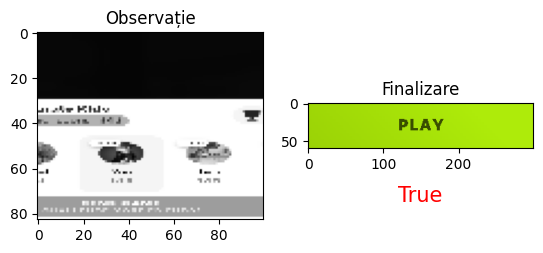

In [59]:
# Crearea obiectului de mediu
env = WebGame()

# Obținerea observației și afișarea acesteia
obs = env.get_observation()

# Crearea subgraficelor
fig, (ax1, ax2) = plt.subplots(1, 2)

# Afișarea primei imagini în primul subgrafic
ax1.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))
ax1.set_title('Observație')

# Obținerea valorilor de finalizare și afișarea acestora
done, done_cap = env.get_done()

# Afișarea celei de-a doua imagini în al doilea subgrafic
ax2.imshow(done_cap)
ax2.set_title('Finalizare')

# Afișarea valorii de done sub imaginea de finalizare
ax2.text(120, done_cap.shape[0] - -50,f"{done}", color='red', fontsize=15, ha='left', va='top')

# Afișarea subgraficelor
plt.show()

2. Test The Env

In [60]:
for episode in range(2): 
    obs = env.reset()
    done = False  
    total_reward = 0
    done = False
    start_time = time.time()
    num_steps = 0
    while not done: 
        observation, reward, done, terminated, info = env.step(env.action_space.sample())
        total_reward += reward
        num_steps += 1
    end_time = time.time()
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    print('Number of steps per second: {:.2f}'.format(num_steps / (end_time - start_time)))

Total Reward for episode 0 is -2.0
Number of steps per second: 2.65
Total Reward for episode 1 is 3.5
Number of steps per second: 1.88


In [64]:
# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker
env_checker.check_env(env)